# Cantera Combustion Modelling

> Author: Elias Aoubala

> Date: 11/05/2025

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np
import cantera as ct

from rocketcea.cea_obj_w_units import CEA_Obj

## 1 - Background

This document contains the authors efforts in performing combustion modelling of the gas generator using Cantera, with the main goal of getting a more accurate performance model for the combustion gas properties.

## 2 - GRI-30

For the modelling of the combustion of N20 with IPA, we will assume a GRI-30 combustion mechanism.

To get a hang of how cantera works, we will do some practice to load up the mechanism and perform reactions.

### 2.1 - Practice

Loading up our mechanism file:

In [9]:
gas = ct.Solution("gri30.yaml")

gas()


  gri30:

       temperature   300 K
          pressure   1.0133e+05 Pa
           density   0.081894 kg/m^3
  mean mol. weight   2.016 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy             26469             53361  J
   internal energy       -1.2108e+06        -2.441e+06  J
           entropy             64910        1.3086e+05  J/K
    Gibbs function       -1.9447e+07       -3.9204e+07  J
 heat capacity c_p             14311             28851  J/K
 heat capacity c_v             10187             20536  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
                H2                 1                 1           -15.717
     [  +52 minor]                 0                 0  



We can set the state of the gas quite simply by defining a tuple of parameters for the combustion.

In [12]:
gas.TP = 1200, 1e5

gas()


  gri30:

       temperature   1200 K
          pressure   1e+05 Pa
           density   0.020206 kg/m^3
  mean mol. weight   2.016 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy        1.3295e+07        2.6802e+07  J
   internal energy        8.3457e+06        1.6825e+07  J
           entropy             85277        1.7192e+05  J/K
    Gibbs function       -8.9037e+07        -1.795e+08  J
 heat capacity c_p             15377             31000  J/K
 heat capacity c_v             11253             22686  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
                H2                 1                 1           -17.991
     [  +52 minor]                 0                 0  



We can even go on to speciy the composition of a given mixture by doing the following. If we use x we refer to the **mole fraction**, while if we use Y we refer to the **mass fraction**

In [14]:
gas.X = "CH4:1, O2:2, N2:7.52"

We can make our life a little easier by defining the compositions using a dictionary which we can import.

In [16]:
phi = 0.8

gas.X = {"CH4": 1, "O2": 2/phi, "N2": 2*3.76/phi}

The standard procedure for changing the composition for a mixture is that it will result in maintaining the density and temperature - thus chaning the pressure.

if we use TPX or similar we can pass through a composition change and a state change of the mixture accordingly.

In [19]:
gas.TPX = 1200, 101325, "CH4:1, O2:2, N2:7.52"

gas()


  gri30:

       temperature   1200 K
          pressure   1.0133e+05 Pa
           density   0.28063 kg/m^3
  mean mol. weight   27.633 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy        8.6193e+05        2.3818e+07  J
   internal energy        5.0087e+05        1.3841e+07  J
           entropy            8914.2        2.4633e+05  J/K
    Gibbs function       -9.8351e+06       -2.7178e+08  J
 heat capacity c_p            1397.3             38611  J/K
 heat capacity c_v            1096.4             30296  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
                O2           0.22014           0.19011           -28.747
               CH4          0.055187          0.095057           -35.961
                N2           0.72467           0.71483           -25.67

We can equilibriate this mixture in many ways, including keeping the temperature and pressure constant (**TP**) or keeping the enthalpy and pressure constant (**HP**).

In our applications, constant enthalpy pressure processes are most representative.

In [21]:
gas.TPX = 300.0, ct.one_atm, "CH4:0.95,O2:2,N2:7.52"
gas.equilibrate("HP")
gas()


  gri30:

       temperature   2188.9 K
          pressure   1.0133e+05 Pa
           density   0.15349 kg/m^3
  mean mol. weight   27.57 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy       -2.4244e+05        -6.684e+06  J
   internal energy       -9.0257e+05       -2.4884e+07  J
           entropy            9804.1         2.703e+05  J/K
    Gibbs function       -2.1703e+07       -5.9836e+08  J
 heat capacity c_p            1500.5             41370  J/K
 heat capacity c_v            1198.9             33055  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
                H2        0.00013397         0.0018322           -26.072
                 H        8.2844e-06        0.00022659           -13.036
                 O        0.00015045        0.00025925           -16.8

## 3 - Adiabatic Flame Temperature Modelling

One of the key things we need to be able to model for in combustion modelling is the adiabatic flame temperature.

Normally, this is extremely simple to do in Cantera, however when accounting for very low mixture ratios it is known that solid graphite can form. In these cases, the traditional methods cannot be utilised for the evaluation of combustion properties.

The following section attempts to perform this modelling following the guide presented online, and compares the result to that produced by `NASA CEA`.

### 3.1 - Methane-Oxygen

In [ ]:
P = 50e5
T = 300

full_species = ct.Species.list_from_file("nasa_gas.yaml")

molecules = ["C", "H", "O", "E"]

specific = []
for species in full_species:

    comp = species.composition

    # we get the keys
    if not any(item not in molecules for item in comp.keys()):
        specific.append(species)

print(len(full_species))
print(len(specific))
gas = ct.Solution(thermo="ideal-gas", species=specific)
graphite = ct.Solution("graphite.yaml")

mix_phases = [(gas, 1.0), (graphite, 0.0)]

fuel_species = "CH4"

npoints = 50
MR = np.linspace(0.3, 8, npoints)

# We also instantiate our object for cea
cea = CEA_Obj(
    oxName="O2",
    fuelName="CH4",
    pressure_units="Bar",
    temperature_units="K",
    density_units="kg/m^3",
    specific_heat_units="J/kg-K",
)

748
132


In [51]:
mix = ct.Mixture(mix_phases)

tad = np.zeros(npoints)
tcea = np.zeros(npoints)
xeq = np.zeros((mix.n_species, npoints))

for i in range(npoints):

    # we set the equivalence ratio of our gas
    gas.Y = {"CH4": 1, "O2": MR[i]}

    mix = ct.Mixture(mix_phases)

    mix.T = T
    mix.P = P

    mix.equilibrate("HP")

    tad[i] = mix.T
    tcea[i] = cea.get_Tcomb(Pc=P/1e5, MR=MR[i])
    xeq[:, i] = mix.species_moles


We can then plot a comparison of the results

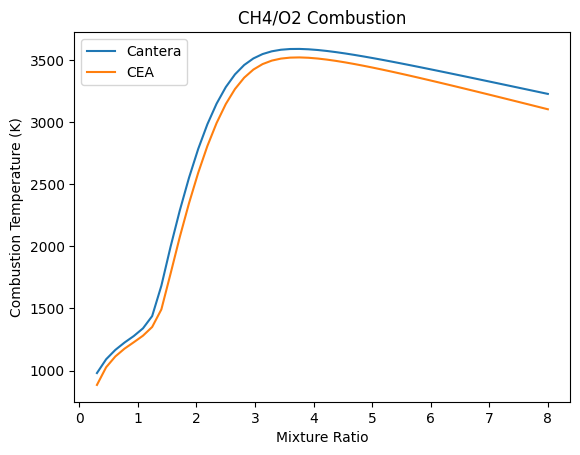

In [52]:
plt.plot(MR, tad, label="Cantera")
plt.plot(MR, tcea, label="CEA")
plt.xlabel("Mixture Ratio")
plt.ylabel("Combustion Temperature (K)")
plt.title("CH4/O2 Combustion")
plt.legend()

### 3.2 - Nitrous-Isopropanol

In [55]:
P = 50e5
T = 300

full_species = ct.Species.list_from_file("nasa_gas.yaml")

molecules = ["C", "H", "O", "E", "N"]

specific = []
for species in full_species:

    comp = species.composition

    # we get the keys
    if not any(item not in molecules for item in comp.keys()):
        specific.append(species)

gas = ct.Solution(thermo="ideal-gas", species=specific)
graphite = ct.Solution("graphite.yaml")

mix_phases = [(gas, 1.0), (graphite, 0.0)]

fuel_species = "C3H8O,2propanol"

npoints = 50
MR = np.linspace(0.3, 8, npoints)

# We also instantiate our object for cea
cea = CEA_Obj(
    oxName="N2O",
    fuelName="Isopropanol",
    pressure_units="Bar",
    temperature_units="K",
    density_units="kg/m^3",
    specific_heat_units="J/kg-K",
)

In [134]:
mix = ct.Mixture(mix_phases)

tad = np.zeros(npoints)
tcea = np.zeros(npoints)
xeq = np.zeros((mix.n_species, npoints))

for i in range(npoints):

    # we set the equivalence ratio of our gas
    gas.Y = {fuel_species: 1, "N2O": MR[i]}

    mix = ct.Mixture(mix_phases)

    mix.T = T
    mix.P = P

    mix.equilibrate("HP")

    tad[i] = mix.T
    tcea[i] = cea.get_Tcomb(Pc=P/1e5, MR=MR[i])
    xeq[:, i] = mix.species_moles

ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!


CanteraError: 
*******************************************************************************
CanteraError thrown by MultiPhaseEquil::MultiPhaseEquil:
condensed-phase speciesC(gr) is excluded since its thermo properties are 
not valid at this temperature, but it has non-zero moles in the initial state.
*******************************************************************************


We can then plot a comparison of the results

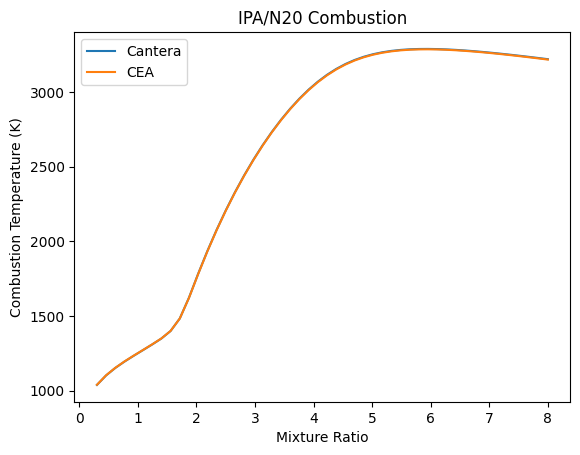

In [63]:
plt.plot(MR, tad, label="Cantera")
plt.plot(MR, tcea, label="CEA")
plt.xlabel("Mixture Ratio")
plt.ylabel("Combustion Temperature (K)")
plt.title("IPA/N20 Combustion")
plt.legend()

### 3.3 - Specific Heat Capacity and Ratio Variation

We will now consider the case where we can evaluate for the specific heat ratio and capacity of the gas considering changes in gas composition.

The way we will do this is by perturbing the gas mixture a little, evaluate for both the enthalpy and internal energy, then re-equilibriate the mixture to thus define the $C_p$, $C_v$ and $\gamma$ terms for the combustion mixture.

The pertubations will be strictly done on the gas subproduct of the mixture under the premise that the solid graphite will not be able to absorb sufficient amounts of heat capacity in the present context.

#### 3.3.1 - Technique #1: Perturb only the Gas

In [ ]:
P = 25e5
T = 300
dt = 1

full_species = ct.Species.list_from_file("nasa_gas.yaml")

molecules = ["C", "H", "O", "E", "N"]

specific = []
for species in full_species:

    comp = species.composition

    # we get the keys
    if not any(item not in molecules for item in comp.keys()):
        specific.append(species)

gas = ct.Solution(thermo="ideal-gas", species=specific)
graphite = ct.Solution("graphite.yaml")

mix_phases = [(gas, 1.0), (graphite, 0.0)]

fuel_species = "C3H8O,2propanol"

npoints = 50
MR = np.linspace(0.5, 3, npoints)

# We also instantiate our object for cea
cea = CEA_Obj(
    oxName="N2O",
    fuelName="Isopropanol",
    pressure_units="Bar",
    temperature_units="K",
    density_units="kg/m^3",
    specific_heat_units="J/kg-K",
)

In [ ]:
mix = ct.Mixture(mix_phases)

cp_can = np.zeros(npoints)
cv_can = np.zeros(npoints)
gamma_can = np.zeros(npoints)

cp_cea = np.zeros(npoints)
cv_cea = np.zeros(npoints)
gamma_cea = np.zeros(npoints)

for i in range(npoints):

    # we set the equivalence ratio of our gas
    gas.Y = {fuel_species: 1, "N2O": MR[i]}

    mix_phases = [(gas, 1.0), (graphite, 0.0)]
    mix = ct.Mixture(mix_phases)

    mix.T = T
    mix.P = P
    mix.equilibrate("HP")

    # We then get the gas enthalpy
    h_o = gas.enthalpy_mass
    d_o = gas.density_mass
    u_o = gas.int_energy_mass
    T_o = gas.T

    # We then perturb the gas mixture
    gas.TP = (T_o + dt, P)

    # We re-equilibriate the gas
    gas.equilibrate("TP")

    # We then get the new enthalpy
    h_1 = gas.enthalpy_mass

    cp_can[i] = (h_1 - h_o)/dt

    # We can then shift the mixture to a point with a fixed density at the perturbed termperature
    gas.TD = (T_o + dt, d_o)

    # We equilibriate
    gas.equilibrate("TV")

    u_1 = gas.int_energy_mass

    cv_can[i] = (u_1 - u_o)/dt

    gamma_can[i] = cp_can[i]/cv_can[i]

    cp_cea[i] = cea.get_Chamber_Cp(Pc = P/1e5, MR = MR[i])
    gamma_cea[i] = cea.get_Chamber_MolWt_gamma(Pc=P / 1e5, MR=MR[i])[1]
    cv_cea[i] = cp_cea[i] / gamma_cea[i]

ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!


CanteraError: 
*******************************************************************************
CanteraError thrown by MultiPhaseEquil::MultiPhaseEquil:
condensed-phase speciesC(gr) is excluded since its thermo properties are 
not valid at this temperature, but it has non-zero moles in the initial state.
*******************************************************************************


We can then plot a comparison of the results

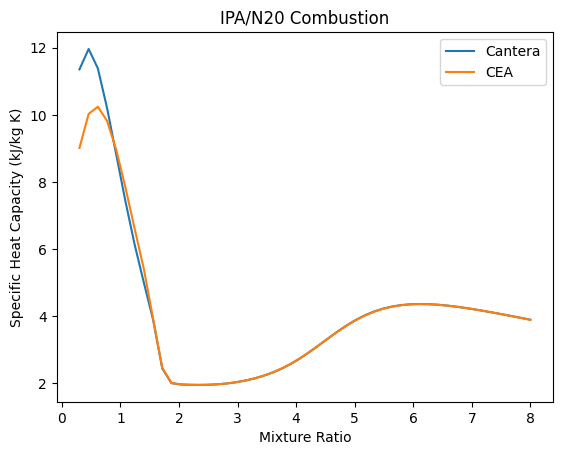

In [156]:
plt.plot(MR, cp_can/1e3, label="Cantera")
plt.plot(MR, cp_cea / 1e3, label="CEA")
plt.xlabel("Mixture Ratio")
plt.ylabel("Specific Heat Capacity (kJ/kg K)")
plt.title("IPA/N20 Combustion")
plt.legend()

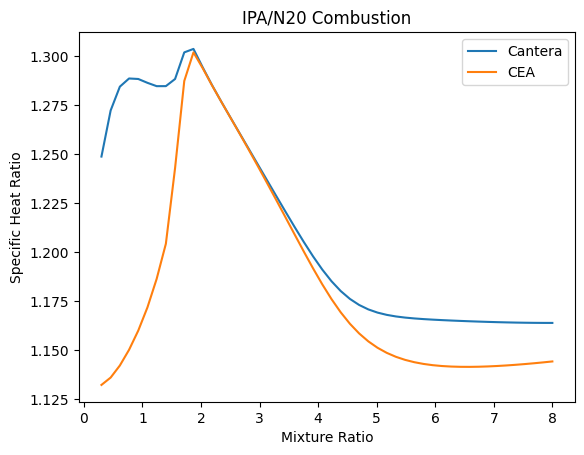

In [162]:
plt.plot(MR, gamma_can, label="Cantera")
plt.plot(MR, gamma_cea, label="CEA")
plt.xlabel("Mixture Ratio")
plt.ylabel("Specific Heat Ratio")
plt.title("IPA/N20 Combustion")
plt.legend()

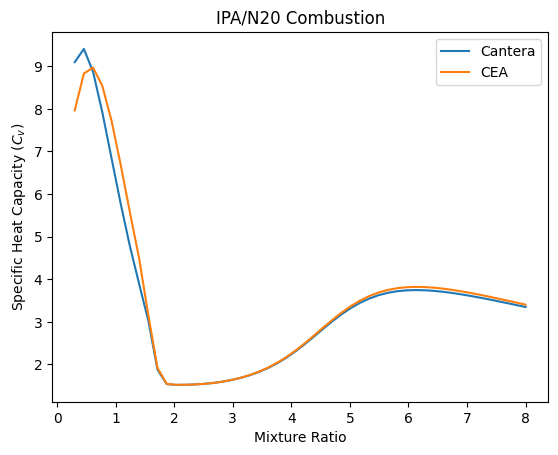

In [161]:
plt.plot(MR, cv_can/1e3, label="Cantera")
plt.plot(MR, cv_cea/1e3, label="CEA")
plt.xlabel("Mixture Ratio")
plt.ylabel("Specific Heat Capacity ($C_v$)")
plt.title("IPA/N20 Combustion")
plt.legend()